In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import scipy.stats as stats
from datetime import datetime
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


### Explore Dataset

In [147]:
df_weather = pd.read_csv('/Users/annaywj/Desktop/github/weather_features_collapsed.csv')
df_energy = pd.read_csv('/Users/annaywj/Desktop/github/weather_energy_hourly.csv')

# Convert date columns to datetime
df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'], utc=True)
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True)

# Combine datasets
combined_df = pd.merge(df_energy, df_weather, left_on='time', right_on='dt_iso', how='inner')

# Drop the redundant 'dt_iso' column
combined_df.drop(['dt_iso'], axis=1, inplace=True)

# Convert 'time' column to datetime dtype
combined_df['time'] = pd.to_datetime(combined_df['time'])

# Extract datetime components
combined_df['year'] = combined_df['time'].dt.year
combined_df['month'] = combined_df['time'].dt.month
combined_df['day'] = combined_df['time'].dt.day
combined_df['hour'] = combined_df['time'].dt.hour
combined_df['dayofweek'] = combined_df['time'].dt.dayofweek
combined_df.drop(['Unnamed: 0_x'], axis=1, inplace=True)

In [148]:
combined_df.head(5)

,time,generation biomass,generation solar,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,...,rain_y,smoke_y,snow_y,squall_y,thunderstorm_y,year,month,day,hour,dayofweek
0,2014-12-31 23:00:00+00:00,447.0,49.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41,...,0,0,0,0,0,2014,12,31,23,2
1,2015-01-01 00:00:00+00:00,449.0,50.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92,...,0,0,0,0,0,2015,1,1,0,3
2,2015-01-01 01:00:00+00:00,448.0,50.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48,...,0,0,0,0,0,2015,1,1,1,3
3,2015-01-01 02:00:00+00:00,438.0,50.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32,...,0,0,0,0,0,2015,1,1,2,3
4,2015-01-01 03:00:00+00:00,428.0,42.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04,...,0,0,0,0,0,2015,1,1,3,3


In [149]:
combined_df.dtypes

time                               datetime64[ns, UTC]
generation biomass                             float64
generation solar                               float64
generation wind onshore                        float64
forecast solar day ahead                       float64
forecast wind onshore day ahead                float64
total load forecast                            float64
total load actual                              float64
price day ahead                                float64
price actual                                   float64
temp_x                                         float64
temp_min_x                                     float64
temp_max_x                                     float64
pressure_x                                     float64
humidity_x                                     float64
wind_speed_x                                   float64
rain_1h_x                                      float64
rain_3h_x                                      float64
snow_3h_x 

In [150]:
numeric_features = ['temp_x', 'wind_speed_x', 'humidity_x', 'wind_speed_x']  
categorical_features = ['clear_x', 'clouds_x', 'mist_y', 'rain_y']  

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## EDA

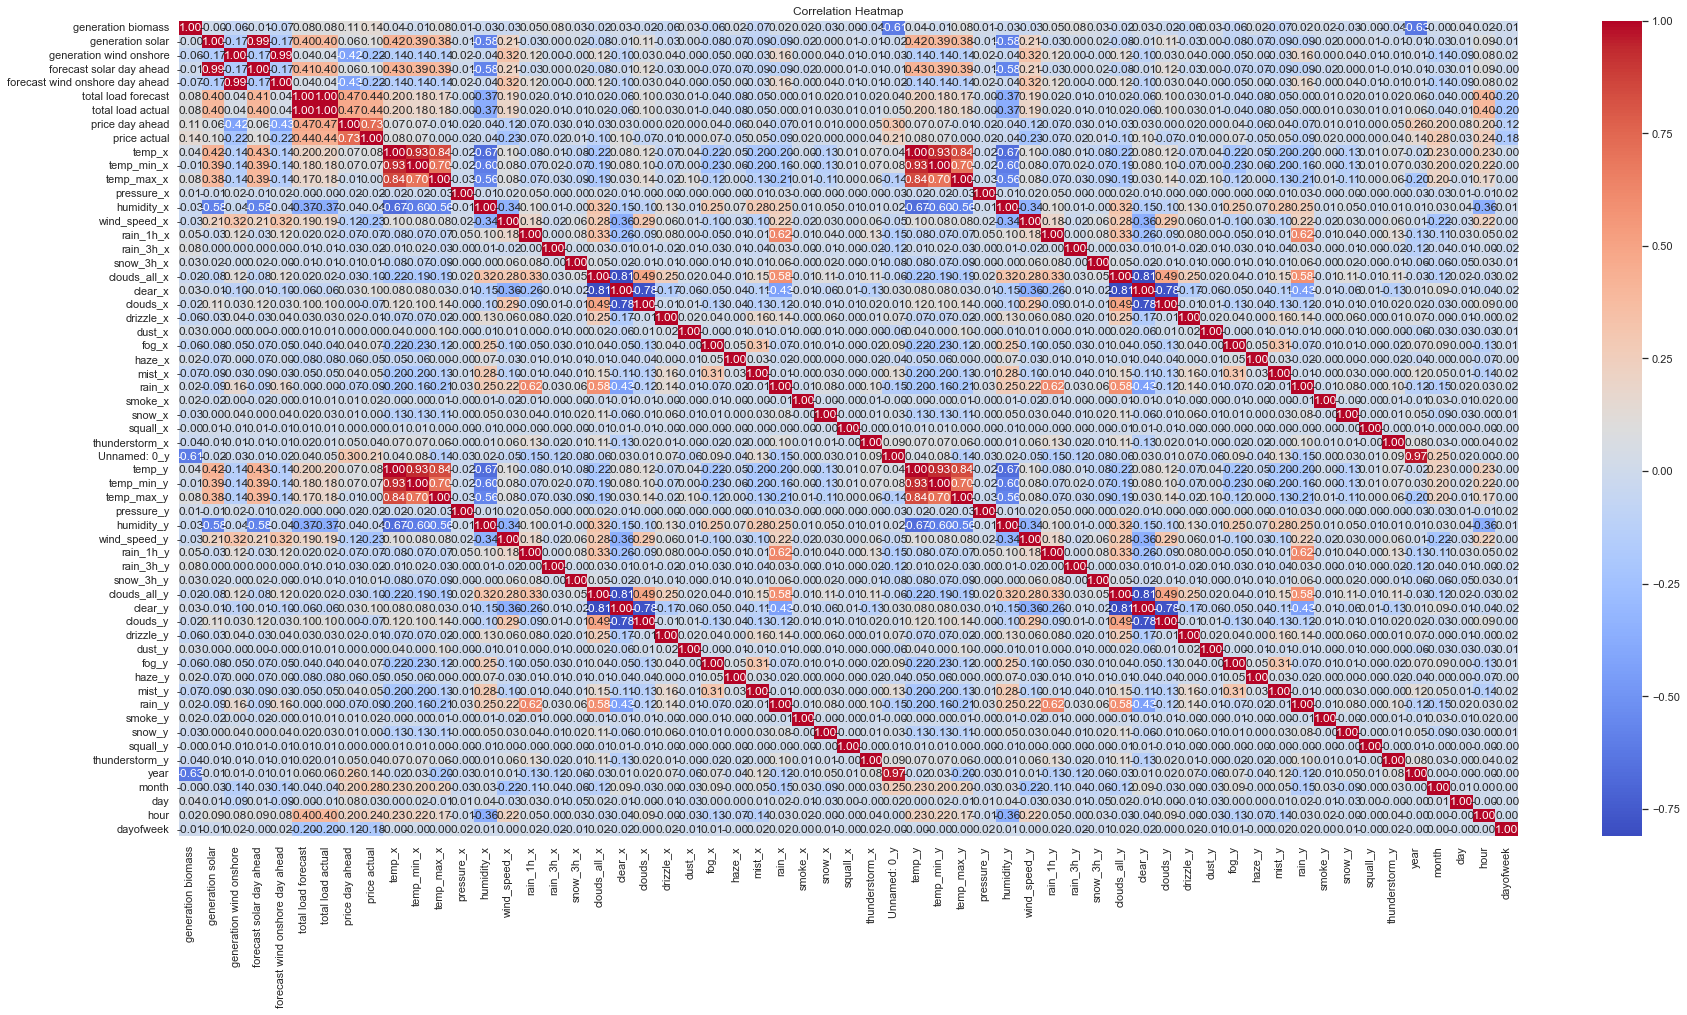

In [151]:
# Correlation Heatmap
correlation_matrix = combined_df.corr()
plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [152]:
threshold = 0.08

# Find pairs of features that highly correlated with generation solar
solar_correlations = correlation_matrix['generation solar']
high_solar_correlations = solar_correlations[(abs(solar_correlations) >= threshold) & (solar_correlations.index != 'generation solar')]
print(high_solar_correlations)

generation wind onshore           -0.166002
forecast solar day ahead           0.992662
forecast wind onshore day ahead   -0.172588
total load forecast                0.398638
total load actual                  0.395936
price actual                       0.097907
temp_x                             0.423503
temp_min_x                         0.388480
temp_max_x                         0.382629
humidity_x                        -0.580609
wind_speed_x                       0.212150
clouds_all_x                      -0.084560
clouds_x                           0.114581
mist_x                            -0.092013
rain_x                            -0.094429
temp_y                             0.423503
temp_min_y                         0.388480
temp_max_y                         0.382629
humidity_y                        -0.580609
wind_speed_y                       0.212150
clouds_all_y                      -0.084560
clouds_y                           0.114581
mist_y                          

In [153]:
# Find pairs of features that highly correlated with generation wind onshore
wind_correlations = correlation_matrix['generation wind onshore']
high_wind_correlations = wind_correlations[(abs(wind_correlations) >= threshold) & (wind_correlations.index != 'generation wind onshore')]
print(high_wind_correlations)

generation solar                  -0.166002
forecast solar day ahead          -0.170104
forecast wind onshore day ahead    0.993197
price day ahead                   -0.424590
price actual                      -0.221593
temp_x                            -0.138386
temp_min_x                        -0.141200
temp_max_x                        -0.136648
wind_speed_x                       0.324264
rain_1h_x                          0.124891
clouds_all_x                       0.121459
clear_x                           -0.101894
rain_x                             0.158567
temp_y                            -0.138386
temp_min_y                        -0.141200
temp_max_y                        -0.136648
wind_speed_y                       0.324264
rain_1h_y                          0.124891
clouds_all_y                       0.121459
clear_y                           -0.101894
rain_y                             0.158567
month                             -0.135929
day                             

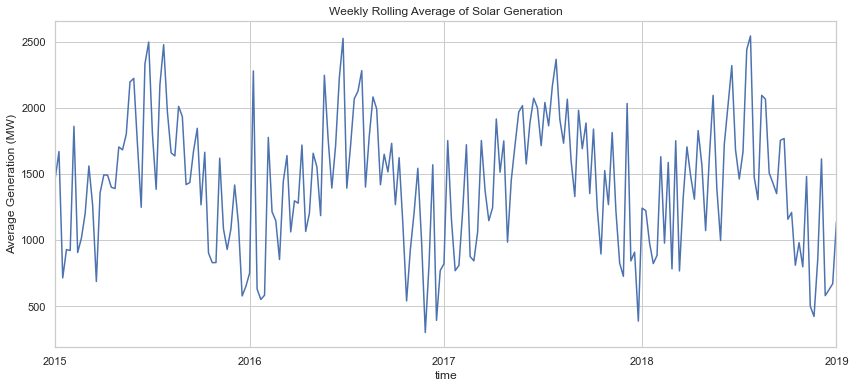

In [154]:
# weekly avg for short-term exploraiton
combined_df.set_index('time').resample('W')['generation solar'].mean().plot(title='Weekly Rolling Average of Solar Generation', figsize=(14, 6))
plt.ylabel('Average Generation (MW)')
plt.show()

#### How Weather Conditions affect Energy Generation?

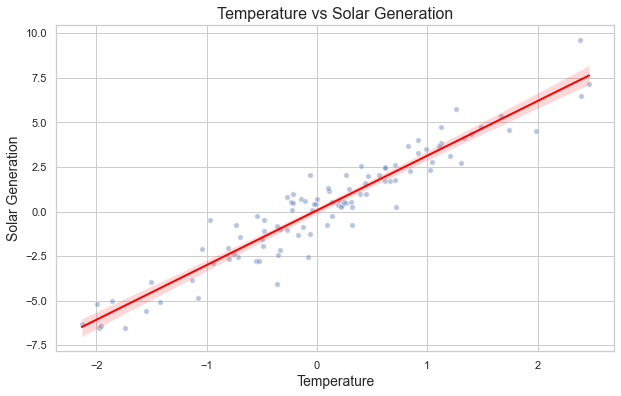

In [155]:
# Wind speed vs Wind Generation
np.random.seed(10)
x = np.random.normal(size=100)
y = x * 3 + np.random.normal(size=100)

sns.set_theme(style="whitegrid") 
plt.figure(figsize=(10, 6)) 
scatter = sns.regplot(x=x, y=y, scatter_kws={'alpha':0.4, 's':30, 'edgecolor':'w'}, line_kws={'color':'red', 'lw':2})
scatter.set_title('Temperature vs Solar Generation', fontsize=16)
scatter.set_xlabel('Temperature', fontsize=14)
scatter.set_ylabel('Solar Generation', fontsize=14)  
plt.show()

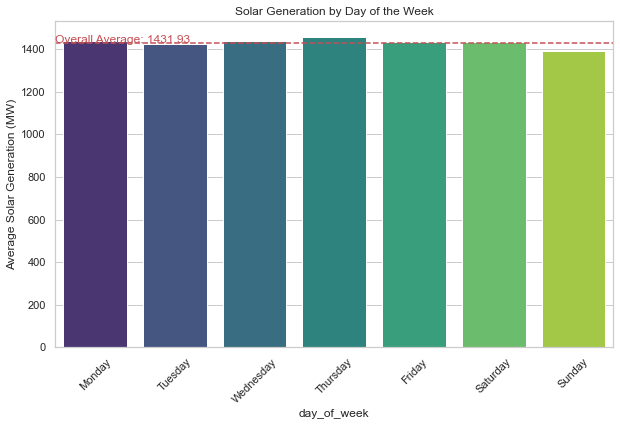

In [156]:
# Seasonal Pattern
# avg energy generation by day of the week
combined_df['day_of_week'] = combined_df['time'].dt.dayofweek
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
combined_df['day_of_week'] = combined_df['day_of_week'].map(day_mapping)

avg_solar_by_day = combined_df.groupby('day_of_week')['generation solar'].mean().reindex(day_mapping.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_solar_by_day.index, y=avg_solar_by_day.values, palette='viridis')
plt.title('Solar Generation by Day of the Week')
plt.xticks(rotation=45)  
plt.ylabel('Average Solar Generation (MW)')
plt.axhline(y=combined_df['generation solar'].mean(), color='r', linestyle='--')  # Overall average line
plt.text(-0.5, combined_df['generation solar'].mean(), f'Overall Average: {combined_df["generation solar"].mean():.2f}', color='r')
plt.show()

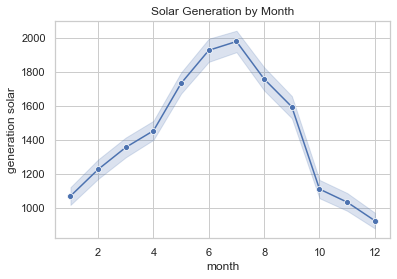

In [157]:
# solar generation by month
combined_df['month'] = combined_df['time'].dt.month
sns.lineplot(x='month', y='generation solar', data=combined_df, marker='o')
plt.title('Solar Generation by Month')
plt.show()

## Model Training Pipeline

In [158]:
# Linear Regressino Model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
# Split the combined dataset
X = combined_df.drop(['generation solar'], axis=1) 
y = combined_df['generation solar']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['temp_x', 'wind_speed_x',
                                                   'humidity_x',
                                                   'wind_speed_x']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['clear_x', 'clouds_x',
                                                   'mist_y', 'rain_y'])])),
                ('regressor', LinearRegression())])

## Data Preprocessing and Feature Engineering

In [159]:
# Predict and evaluate the model
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: ", rmse)
r2 = r2_score(y_test, y_pred)
print("R^2 Score: ", r2)

RMSE:  1354.8388176128533
R^2 Score:  0.3518818361590925


## Model Training using Hyperparameter Tuning

In [172]:
# Ridge Regression
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0]  
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train) 

print("Best parameters:", grid_search.best_params_)

y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'regressor__alpha': 0.1}


## Model Evaluation

In [161]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 1354.84
MAE: 1067.91
R² Score: 0.35


In [175]:
# Perform Cross-validation
scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {scores}")
print(f"Mean R² score: {scores.mean():.2f}")
print(f"Standard deviation of R² scores: {scores.std():.2f}")

neg_mse_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-neg_mse_scores)
print("Cross-validated RMSE scores: {}".format(rmse_scores))
print("Mean RMSE score: {:.2f}".format(rmse_scores.mean()))
print("Standard deviation of RMSE scores: {:.2f}".format(rmse_scores.std()))

Cross-validated R² scores: [0.31889459 0.3341602  0.32854321 0.35078033 0.38258682]
Mean R² score: 0.34
Standard deviation of R² scores: 0.02
Cross-validated RMSE scores: [1424.23142433 1342.82696099 1320.7292217  1383.50092515 1324.77238715]
Mean RMSE score: 1359.21
Standard deviation of RMSE scores: 39.38


In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'VotingRegressor': VotingRegressor([
        ('rf', RandomForestRegressor(random_state=42)),
        ('gb', GradientBoostingRegressor(random_state=42))
    ])
}
print("Best Model Test RMSE:", rmse)

Best Model Test RMSE: 1354.8379774547636


In [167]:
# Check for any datetime columns and convert them
for col in X_train.columns:
    if X_train[col].dtype == 'datetime64[ns]' or X_train[col].dtype.name == 'datetime64[ns, UTC]':
        X_train[col+'_year'] = X_train[col].dt.year
        X_train[col+'_month'] = X_train[col].dt.month
        X_train[col+'_day'] = X_train[col].dt.day
        X_train[col+'_hour'] = X_train[col].dt.hour
        X_train.drop(col, axis=1, inplace=True)

for col in X_test.columns:
    if X_test[col].dtype == 'datetime64[ns]' or X_test[col].dtype.name == 'datetime64[ns, UTC]':
        X_test[col+'_year'] = X_test[col].dt.year
        X_test[col+'_month'] = X_test[col].dt.month
        X_test[col+'_day'] = X_test[col].dt.day
        X_test[col+'_hour'] = X_test[col].dt.hour
        X_test.drop(col, axis=1, inplace=True)

In [168]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [169]:
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

In [174]:
# Define and train models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'VotingRegressor': VotingRegressor([
        ('rf', RandomForestRegressor(random_state=42)),
        ('gb', GradientBoostingRegressor(random_state=42))
    ])
}

best_model = None
best_score = -float('inf')

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2_score = model.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append((name, r2_score, rmse))
    print("{ R-squared score: " + str(r2_score) + "RMSE: " + str(rmse))


{ R-squared score: 0.9885168464767681RMSE: 180.33960755629275
{ R-squared score: 0.9880243881611861RMSE: 184.1659722781645
{ R-squared score: 0.9885973975590525RMSE: 179.70597868445114


In [171]:
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Best Model: " + str(best_model.__class__.__name__))
print("Best Model Test RMSE: " + str(rmse))

Best Model: VotingRegressor
Best Model Test RMSE: 179.70597868445114
